This script will scrape all the product on one selected keyword and will send all the "deals" (the item with price below the average) in the channel of deals on Telegram.
The link for the deals channel is : https://t.me/dealsonamazonpro

In [1]:
#import all library
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import time
import schedule
import requests
import seaborn as sns
import numpy as np
from selenium.webdriver.edge.options import Options
import matplotlib.pyplot as plt




## Broswer CHROME ##

In [ ]:
# assign your website to scrape , in this case amazon
web = 'https://www.amazon.com'
options = webdriver.ChromeOptions()

driver = webdriver.Chrome()
driver.get(web)

driver.implicitly_wait(5)
# select the keyword to Scrape
keyword = "wireless"
search = driver.find_element(By.ID, 'twotabsearchtextbox')
search.send_keys(keyword)
# click search button
search_button = driver.find_element(By.ID, 'nav-search-submit-button')
search_button.click()

driver.implicitly_wait(5)

# Broswer Edge 
you need to download the Microsoft Edge WebDriver file of the right version of your broswer.
Here is the link : https://developer.microsoft.com/en-us/microsoft-edge/tools/webdriver/

In [32]:
def searchOnAmazon(keyword):
    # create object
    #options = Options()
    #options.add_experimental_option("detach", True)

    # open browser and navigate to facebook
    web = 'https://www.amazon.com'
    driver.get(web)
    driver.implicitly_wait(25)
    # select the keyword to Scrape
    search = driver.find_element(By.ID, 'twotabsearchtextbox')
    search.send_keys(keyword)
    # click search button
    search_button = driver.find_element(By.ID, 'nav-search-submit-button')
    search_button.click()
    driver.implicitly_wait(5)
    
    


In [124]:
#SCRAping function
#we made 2 cycle , to identify the page across amazon , the first page have  different xpath , the pages after 2 have the same xpath
def scrape(num_items):
    #we create a dataframe to collect all data scraped
    product_name = []
    product_asin = []
    product_price = []
    product_ratings = []
    product_ratings_num = []
    product_link = []
    product_page = []
    link = []
    link_image = []
    df = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' , 'page' , 'link_image','discount'])
    df = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' , 'page' , 'link_image' , 'discount'])
    #collect all data and create df with all data
    count = 0
    
    for i in range(1,20):
        #the item are the boxes of the product
        # find link
        boxlinks = driver.find_elements(By.XPATH, '//a[@class="a-link-normal s-underline-text s-underline-link-text s-link-style a-text-normal"]')
        for boxlink in boxlinks:
            link.append(boxlink.get_attribute('href'))

        # find link image
        boxlinks = driver.find_elements(By.XPATH, './/img[@class="s-image"]')
        for boxlink in boxlinks:
            link_image.append(boxlink.get_attribute('src'))
        
        items = wait(driver, 10).until(EC.presence_of_all_elements_located((By.XPATH, '//div[contains(@class, "s-result-item s-asin")]')))
        for item in items:
            count = count +1
            if count > num_items:
                return df
            # find name
            name = item.find_element(By.XPATH, './/span[@class="a-size-medium a-color-base a-text-normal"]')
            product_name.append(name.text)

            # find price
            whole_price = item.find_elements(By.XPATH, './/span[@class="a-price-whole"]')
            fraction_price = item.find_elements(By.XPATH, './/span[@class="a-price-fraction"]')
            
    

            if whole_price != [] and fraction_price != []:
                price = '.'.join([whole_price[0].text, fraction_price[0].text])
            else:
                price = 0
            product_price.append(price)
            
            # to continue
            discount = None

            # find ratings box
            ratings_box = item.find_elements(By.XPATH, './/div[@class="a-row a-size-small"]/span')

            # find ratings and ratings_num
            if ratings_box != []:
                ratings = ratings_box[0].get_attribute('aria-label')
                ratings_num = ratings_box[1].get_attribute('aria-label')
            else:
                ratings, ratings_num = 0, 0

            product_ratings.append(ratings)
            product_ratings_num.append(str(ratings_num))
            page = i
            product_page.append(page)
            #add a line on dataframe
            new_row = {'Name':name.text, 'price':str(price), 'rating':str(ratings), '#rating':str(ratings_num) , 'link':link[count-1] , 'link_image':link_image[count-1] , 'page':page , 'discount':discount}
            df = df.append(new_row, ignore_index=True)
        page_button = driver.find_element(By.XPATH, '//a[@class="s-pagination-item s-pagination-next s-pagination-button s-pagination-separator"]')
        page_button.click()
        time.sleep(2)  
            
    driver.quit()
    #convert rating in cutted string
    for i, row in df.iterrows():
        ifor_val = 2
        txt=df.at[i,'rating']
        x = str(txt).split(" ", 1)
        df.at[i,'rating'] = str(x[0])

    #send data to the channel   
    #send_data()
    return df
    



In [82]:
def avg_price() : 
    #Analyze price - rating
    for i, row in df.iterrows():
        ifor_val = 2
        txt=df.at[i,'rating']
        x = str(txt).split(".", 1)
        df.at[i,'rating'] = str(x[0])
    import seaborn as sns
    import numpy as np
    df['price'] = df['price'].astype(np.float)
    df['rating'] = df['rating'].astype(np.float)
    avg = df["price"].mean()
    print(avg)
    graph=sns.barplot(y=df['price'], x=df['rating'])
    graph.axhline(avg)
    return avg



In [83]:
#ritorna i prodotti con un prezzo inferiore ad una threshold
def item_below_threshold(treshold , df) : 
    df = df[df['price'] <= treshold]
    return df

In [84]:
#we send data as message on channel on telegram --> da rivedere perchè non funziona
#step:
# 1. create bot and extract token
# 2. add the bot to a new channel and extract the chat_id
def send_data(df):
    TOKEN = "5532274185:AAGE8CQOwV6i6VtER1xBAfhciVv4WBDSLWA"
    chat_id = "-1001774376845"

    for row in df.itertuples():
        str_link = row.link
        str_name = row.Name
        str_price = row.price
        print("🔴 ",str_price," 🔴","\n",str_name,"\n",str_link)
        text = "🔴 "+str(str_price)+" $"+" 🔴"+"%0A"+str_name+"%0A"+str_link
        #text = "ciaooooo"
        url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={text}"
        #we can select the ratio of messages
        time.sleep(2)
        r = requests.get(url)
        print(r.json())


In [85]:
#advanced send message
import telebot
from telebot import types


#we send data as message on channel on telegram --> da rivedere perchè non funziona
#step:
# 1. create bot and extract token
# 2. add the bot to a new channel and extract the chat_id
def send_data_2(df):
    TOKEN = "5532274185:AAGE8CQOwV6i6VtER1xBAfhciVv4WBDSLWA"
    chat_id = "-1001774376845"
    bot = telebot.TeleBot(TOKEN)    #create a new Telegram Bot object

    for row in df.itertuples():
        str_link = row.link
        str_name = row.Name
        str_rating = row.rating
        str_price = row.price
        link_image = row.link_image
        print("        🔴 ",str_price,"$   🔴","\n",str_name,"\n",str_link)
        tg_message_to_send = "Price =     🔴  "
        tg_message_to_send += str(str_price)
        tg_message_to_send += "$  🔴"
        tg_message_to_send += "\n"
        tg_message_to_send += "Rating =  "
        for x in range(int(str_rating)):
            tg_message_to_send += "⭐"
        tg_message_to_send += "\n"
        tg_message_to_send += str_name
        
        time.sleep(2)
        tg_markup = types.InlineKeyboardMarkup(row_width=2)
        tg_itembtn1 = types.InlineKeyboardButton("👉 Link 👈", str_link)
        tg_markup.add(tg_itembtn1)
        bot.send_photo(chat_id,link_image)
        bot.send_message(chat_id, tg_message_to_send, parse_mode = 'HTML', reply_markup = tg_markup, disable_web_page_preview=False)


In [86]:
#send message to channel
def send_message(text):
    #serve a mandare i messaggi sul canale
    import time
    import schedule
    import requests

    import requests
    TOKEN = "5532274185:AAGE8CQOwV6i6VtER1xBAfhciVv4WBDSLWA"
    chat_id = "-1001774376845"
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={text}"
    # url = f"https://api.telegram.org/bot{TOKEN}/getUpdates"
    r = requests.get(url)
    print(r.json())

# MAIN with single search item (edge)

C:\Users\Armillotta\AppData\Local\Temp\ipykernel_7512\277399341.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_7512\277399341.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_7512\277399341.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_7512\1536252316.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If

                                                Name  price  \
0  Amazon Basics Wireless Computer Mouse with USB...   9.99   
1  INPHIC Wireless Mouse 700mAh Large Ergonomic R...  10.65   
2  TECKNET Wireless Mouse, 2.4G Ergonomic Optical...   8.79   

               rating #rating  \
0  4.5 out of 5 stars  54,905   
1  4.3 out of 5 stars  16,121   
2  4.5 out of 5 stars  53,251   

                                                link page  \
0  https://www.amazon.com/gp/slredirect/picassoRe...    1   
1  https://www.amazon.com/gp/slredirect/picassoRe...    1   
2  https://www.amazon.com/TeckNet-Ergonomic-Wirel...    1   

                                          link_image discount  
0  https://m.media-amazon.com/images/I/51jojZahYR...     None  
1  https://m.media-amazon.com/images/I/61AWLK29Yr...     None  
2  https://m.media-amazon.com/images/I/61tk-+W5dz...     None  
9.81
                                                Name  price  rating #rating  \
2  TECKNET Wireless Mouse, 2.

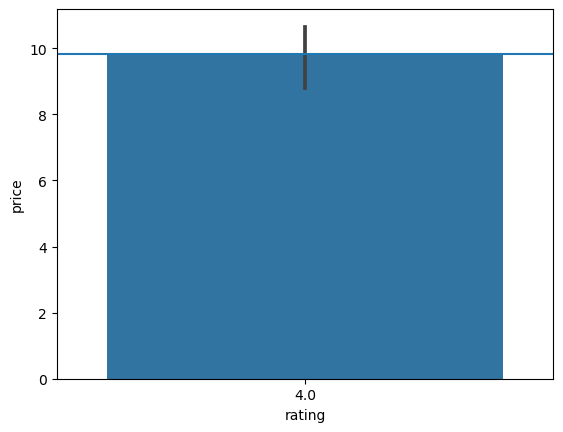

In [125]:
'''
This pipeline made the following steps :
    0. Set the scraper 
    1. Start the scraper on the website for the keyword
    2. Filter the result below the average
    3. Send result to telegram
'''
#0. Settings
#select number of item to scrape
num_of_item_to_scrape = 3
#select the keyword to scrape

keyword = "wireless mouse"

driver = webdriver.Edge(r"C:\Users\Armillotta\Downloads\msedgedriver.exe")

searchOnAmazon(keyword)

#1. Scraping
df = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' ,'link_image', 'page','discount'])  

df = scrape(num_of_item_to_scrape)
print(df)


#2. return all item below the avg
avg = avg_price()
df_below_avg = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' ,'link_image', 'page','discount'])  

df_below_avg = item_below_threshold(avg , df)
print(df_below_avg)

#3. pass the df with item below average to send to channel
#text with button
send_data_2(df_below_avg) 

In [107]:
#________________________TESTS__________________


df

,Name,price,rating,#rating,link,page,link_image
0,Amazon Basics Wireless Computer Mouse with USB...,9.99,4.0,"54,905",https://www.amazon.com/gp/slredirect/picassoRe...,1,https://m.media-amazon.com/images/I/51jojZahYR...
1,"WisFox 2.4G Wireless Mouse for Laptop, Ergonom...",11.99,4.0,"3,587",https://www.amazon.com/gp/slredirect/picassoRe...,1,https://m.media-amazon.com/images/I/714+t9HR4G...
2,"Logitech MX Anywhere 2S Mouse Graphite, Wirele...",58.00,4.0,137,https://www.amazon.com/Logitech-Anywhere-Graph...,1,https://m.media-amazon.com/images/I/6170mJHIsY...


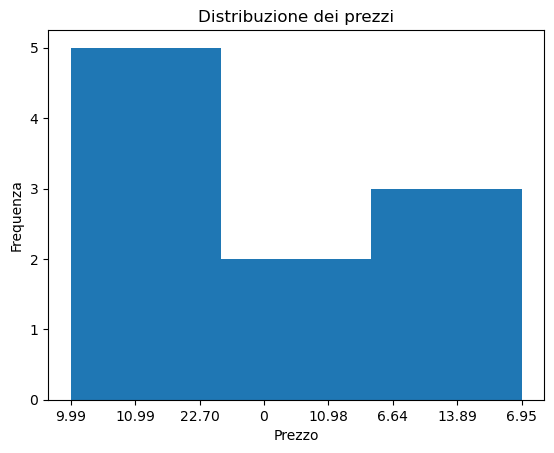

In [41]:
import matplotlib.pyplot as plt

plt.hist(df['price'], bins=3)
plt.title('Distribuzione dei prezzi')
plt.xlabel('Prezzo')
plt.ylabel('Frequenza')
plt.show()


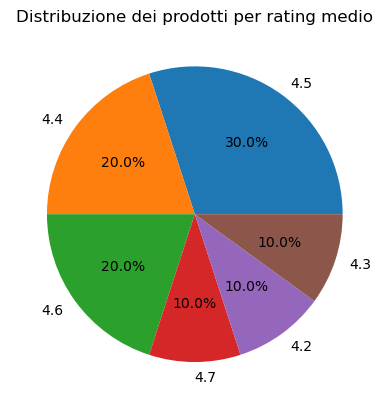

In [50]:
import matplotlib.pyplot as plt

counts = df['rating'].value_counts()
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribuzione dei prodotti per rating medio')
plt.show()


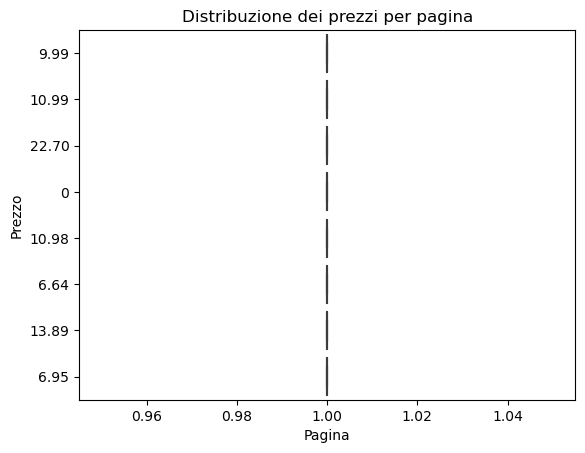

In [52]:
import seaborn as sns

sns.boxplot(x='page', y='price', data=df)
plt.title('Distribuzione dei prezzi per pagina')
plt.xlabel('Pagina')
plt.ylabel('Prezzo')
plt.show()


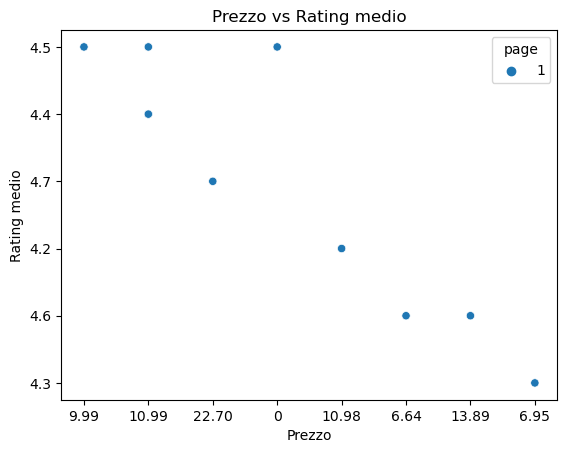

In [54]:
import seaborn as sns

sns.scatterplot(x='price', y='rating', data=df, hue='page')
plt.title('Prezzo vs Rating medio')
plt.xlabel('Prezzo')
plt.ylabel('Rating medio')
plt.show()


# MAIN with multiple search item (edge)

pc_portatile


C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\2630575205.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\2630575205.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\2630575205.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\2630575205.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=Tr

                                                Name   price rating #rating  \
0  Acer Aspire Vero AV15-51-7617 Green PC | 15.6"...  509.99    4.4     401   
1  CHUWI HeroBox Mini PC,Windows 11 Mini Desktop ...  149.00    4.0     875   
2  Lenovo 2022 Newest Ideapad 3 Laptop, 15.6" HD ...  382.00    4.4   2,538   
3  Microsoft Surface Laptop Go 12.4in Touchscreen...  255.00    4.4     331   
4  ASUS E410 Intel Celeron N4020 4GB 64GB 14-Inch...  185.00    4.2     477   
5  CHUWI HeroBook Pro 14.1'' Laptop, 8GB RAM 256G...  199.99    3.9   1,613   
6  ASUS Chromebook CX1, 14" Full HD NanoEdge Disp...  174.00    3.9      84   
7  Lenovo 2022 Newest 14" HD Laptop Computer for ...  199.00    4.1      29   
8  Newest HP 2-in-1 Convertible Chromebook, 14inc...  208.00    4.7      22   
9  HP 14-inch Chromebook HD Touchscreen Laptop PC...  230.00    4.5   2,530   

                                                link page  
0  https://www.amazon.com/gp/slredirect/picassoRe...    1  
1  https:/

C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\1536252316.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['price'] = df['price'].astype(np.float)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\1536252316.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['rating'] = df['rating'].astype(np.float)


{'ok': True, 'result': {'message_id': 79, 'sender_chat': {'id': -1001774376845, 'title': 'Deals on Amazon', 'username': 'dealsonamazonpro', 'type': 'channel'}, 'chat': {'id': -1001774376845, 'title': 'Deals on Amazon', 'username': 'dealsonamazonpro', 'type': 'channel'}, 'date': 1681066593, 'text': '🔴 149.0 $ 🔴\nCHUWI HeroBox Mini PC,Windows 11 Mini Desktop Computer,Intel 11th Gen N5100 Quad Core Processor(2.9GHz), 8GB RAM 256GB SSD,Dual WiFi/BT/Gigabit Ethernet/VESA / 4K UHD/USB 3.0/Up to 2TB SSD\nhttps://www.amazon.com/gp/slredirect/picassoRedirect.html/ref=pa_sp_btf_aps_sr_pg1_1?ie=UTF8', 'entities': [{'offset': 203, 'length': 92, 'type': 'url'}]}}
🔴  185.0  🔴 
 ASUS E410 Intel Celeron N4020 4GB 64GB 14-Inch HD LED Win 10 Laptop (Star Black) 
 https://www.amazon.com/gp/slredirect/picassoRedirect.html/ref=pa_sp_btf_aps_sr_pg1_1?ie=UTF8&adId=A06002171VQVSV1JTTAW6&qualifier=1681066583&id=2784409618689306&widgetName=sp_btf&url=%2FALLDOCUBE-11st-gen-JasperLake-Bluetooth-Keyboard%2Fdp%2FB0

C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\2630575205.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\2630575205.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\2630575205.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\2630575205.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=Tr

                                                Name  price rating #rating  \
0  Amazon Basics Wireless Computer Mouse with USB...   9.99    4.5  54,721   
1  VssoPlor Wireless Mouse, 2.4G Slim Portable Co...  11.98    4.6  15,053   
2  TECKNET Wireless Mouse, 2.4G Ergonomic Optical...  10.99    4.5  52,987   
3  Logitech M510 Wireless Computer Mouse for PC w...  22.70    4.7  24,533   
4  HP X3000 G2 Wireless Mouse - Ambidextrous 3-Bu...  13.89    4.6  20,456   
5  INPHIC Wireless Mouse 700mAh Large Ergonomic R...  12.99    4.3  15,931   
6  Amazon Basics 3-Button Wired USB Computer Mous...   6.64    4.6  71,684   
7  HOTLIFE LED Wireless Mouse, Slim Rechargeable ...   6.95    4.3   5,648   
8  【Upgrade】 LED Wireless Mouse, Rechargeable Sli...  10.98    4.2  43,223   
9  Logitech G305 LIGHTSPEED Wireless Gaming Mouse...      0    4.7  23,316   

                                                link page  
0  https://www.amazon.com/gp/slredirect/picassoRe...    1  
1  https://www.amazon

C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\1536252316.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['price'] = df['price'].astype(np.float)
C:\Users\Armillotta\AppData\Local\Temp\ipykernel_20392\1536252316.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['rating'] = df['rating'].astype(np.float)


{'ok': True, 'result': {'message_id': 86, 'sender_chat': {'id': -1001774376845, 'title': 'Deals on Amazon', 'username': 'dealsonamazonpro', 'type': 'channel'}, 'chat': {'id': -1001774376845, 'title': 'Deals on Amazon', 'username': 'dealsonamazonpro', 'type': 'channel'}, 'date': 1681066636, 'text': '🔴 9.99 $ 🔴\nAmazon Basics Wireless Computer Mouse with USB Nano Receiver - Black\nhttps://www.amazon.com/gp/slredirect/picassoRedirect.html/ref=pa_sp_btf_aps_sr_pg1_1?ie=UTF8', 'entities': [{'offset': 82, 'length': 92, 'type': 'url'}]}}
🔴  6.64  🔴 
 Amazon Basics 3-Button Wired USB Computer Mouse, Black 
 https://www.amazon.com/gp/slredirect/picassoRedirect.html/ref=pa_sp_btf_aps_sr_pg1_1?ie=UTF8&adId=A0844849GJOJPJQB21TH&qualifier=1681066615&id=3632898567874045&widgetName=sp_btf&url=%2FAmazonBasics-Ergonomic-Wireless-Mouse-adjustable%2Fdp%2FB0787D6SGQ%2Fref%3Dsr_1_22_ffob_sspa%3Fkeywords%3Dmouse%2Bwireless%26qid%3D1681066615%26sr%3D8-22-spons%26psc%3D1
{'ok': True, 'result': {'message_id': 

KeyboardInterrupt: 

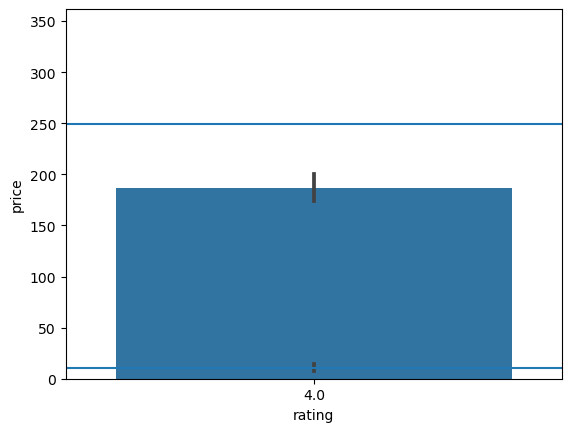

In [82]:
#crea un dizionario di parole chiavi da ricercare , per ogni parola chiave:
# 1. fa lo scraping e mette in un dataframe
# 2. calcola l'avg
# 3. filtra i risultati
# 4. li manda sul canale telegram

#ATTENZIONE = il nome da ricercare metterlo sul dizionario separato con "_" , che verra sostituito con lo spazio
import pandas as pd
import re


# Creazione di due dataframe
df1 = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' , 'page'])
df2 = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' , 'page'])
df3 = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' , 'page'])


# Creazione del dizionario di dataframe
my_dict = {'pc_portatile': df1, 'mouse wireless': df2 , 'hard_disk': df3}

# Iterazione su tutte le chiavi del dizionario
for key in my_dict.keys():
    # Accesso al dataframe tramite la chiave
    df = my_dict[key]
    print(key)
    search_string = re.sub("_", " ", key)
    driver = webdriver.Edge(r"C:\Users\Armillotta\Downloads\msedgedriver.exe")
    searchOnAmazon(search_string)
    
    #scraping
    df = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' , 'page'])  
    num_of_item_to_scrape = 10
    df = scrape(num_of_item_to_scrape)
    print(df)
    
    #return all item below the avg
    avg = avg_price()
    df_below_avg = pd.DataFrame(columns=['Name','price','rating','#rating' , 'link' , 'page'])  

    df_below_avg = item_below_threshold(avg , df)
    print(df_below_avg)

    #pass the df with item below average to send to channel
    #channelName = dealsonamazonpro
    send_data_2(df_below_avg) #--> with button
    